In [9]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [10]:
# Gettint the dataset
root = "data/"

transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

train_ds = datasets.Flowers102(root,split="train",transform=transform,download=True)
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32)

100%|██████████| 345M/345M [01:04<00:00, 5.37MB/s] 


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 574kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 21.5MB/s]


In [3]:
def plot_image(x):
    x = x.permute(1, 2, 0)
    plt.imshow(x.numpy())

def get_betas(T):
    beta_start = 1e-4
    beta_end = 0.1
    betas = torch.linspace(beta_start, beta_end, T)
    return betas

def calculate_alpha(betas):
    alphas = 1 - betas
    alphas_tilda = torch.cumprod(alphas, dim=0)
    return alphas, alphas_tilda

def dummy_forward(x0, T, alpha_tilda, device="cuda"):
    sqrt_alpha_tilda_t = torch.sqrt(alpha_tilda[T-1]).to(device)
    sqrt_one_minus_alpha_tilda_t = torch.sqrt(1 - alpha_tilda[T-1]).to(device)

    epsilon = torch.randn_like(x0).to(device)

    xt = sqrt_alpha_tilda_t * x0 + sqrt_one_minus_alpha_tilda_t * epsilon
    return xt.to(device)

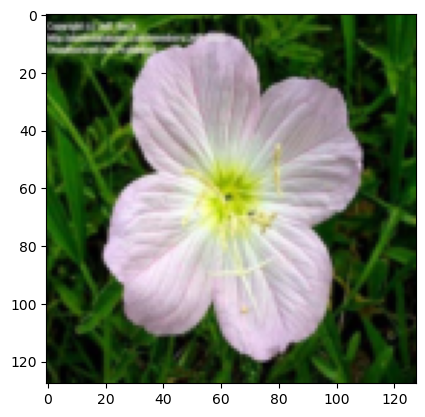

In [4]:
x,y = train_ds[1]
plot_image(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02660795..1.0118492].


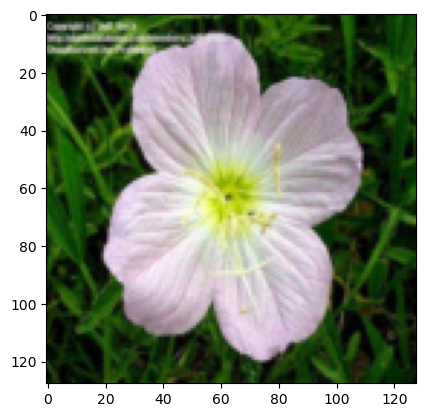

In [5]:
T = 1
device = "cpu"
x.to(device)
betas = get_betas(T)
_,alpha_tilda = calculate_alpha(betas)

xT = dummy_forward(x,T,alpha_tilda,device)
plot_image(xT)

In [6]:
class DownScale(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(output_channels)
        self.pooling = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pooling(x)
        x = self.bn(x)
        return x

class UppScale(nn.Module):
    def __init__(self, input_channels, output_skip_channels, output_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(input_channels + output_skip_channels, output_channels, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self, x_input, x_skip):
        x = torch.cat((x_input, x_skip), dim=1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.ModuleList([
            DownScale(3,64),
            DownScale(64,128),
            DownScale(128,256),
            DownScale(256,512)
        ])

        self.decoder = nn.ModuleList([
            UppScale(512,512,512),
            UppScale(256,512,256),
            UppScale(128,256,128),
            UppScale(128,64,3),
        ])

    def forward(self, x):
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)

        skip_connections = skip_connections[::-1]

        for idx, up in enumerate(self.decoder):
            x = up(x, skip_connections[idx])

        return x


In [7]:
model = UNet()
aux = torch.randn(1, 3, 128, 128)
model(aux).shape

torch.Size([1, 3, 128, 128])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27816105..7.252476].


Epoch 1/100, Loss: 1.2557540126144886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24809292..8.364533].


Epoch 2/100, Loss: 1.2248295284807682


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2340102..8.75118].


Epoch 3/100, Loss: 1.1964971870183945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20374177..8.447271].


Epoch 4/100, Loss: 1.1719081476330757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17780267..8.639149].


Epoch 5/100, Loss: 1.148838546127081


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1576941..6.5150127].


Epoch 6/100, Loss: 1.128689005970955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14654694..7.469008].


Epoch 7/100, Loss: 1.1102360114455223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14025864..6.589039].


Epoch 8/100, Loss: 1.093714665621519


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13553156..5.997441].


Epoch 9/100, Loss: 1.0801608450710773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12813121..5.313251].


Epoch 10/100, Loss: 1.0680817812681198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11748925..4.951704].


Epoch 11/100, Loss: 1.0570229217410088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.106714495..4.200831].


Epoch 12/100, Loss: 1.0472513400018215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.099681854..3.738018].


Epoch 13/100, Loss: 1.0395930260419846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09315601..3.1388679].


Epoch 14/100, Loss: 1.0327115915715694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08212869..3.07528].


Epoch 15/100, Loss: 1.0265165753662586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07159016..3.2704904].


Epoch 16/100, Loss: 1.0216962210834026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.066444054..2.8973103].


Epoch 17/100, Loss: 1.017423391342163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057840493..2.380201].


Epoch 18/100, Loss: 1.014167558401823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05110005..2.0209758].


Epoch 19/100, Loss: 1.0115862935781479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044174522..2.1033444].


Epoch 20/100, Loss: 1.008987806737423


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041800957..1.4277103].


Epoch 21/100, Loss: 1.0068155340850353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037159655..1.546873].


Epoch 22/100, Loss: 1.0054702088236809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03396912..1.0365794].


Epoch 23/100, Loss: 1.0039734281599522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026843878..0.9771424].


Epoch 24/100, Loss: 1.003333393484354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025234122..0.912653].


Epoch 25/100, Loss: 1.0027696788311005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021588674..0.618426].


Epoch 26/100, Loss: 1.0018604658544064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016604876..0.76937646].


Epoch 27/100, Loss: 1.0014520827680826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016177658..0.5567522].


Epoch 28/100, Loss: 1.0012609735131264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014601198..0.39242867].


Epoch 29/100, Loss: 1.0005586128681898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010318465..0.44013137].


Epoch 30/100, Loss: 1.0004291590303183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009940531..0.35902336].


Epoch 31/100, Loss: 1.0004103742539883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008467291..0.23071253].


Epoch 32/100, Loss: 1.00042774528265


KeyboardInterrupt: 

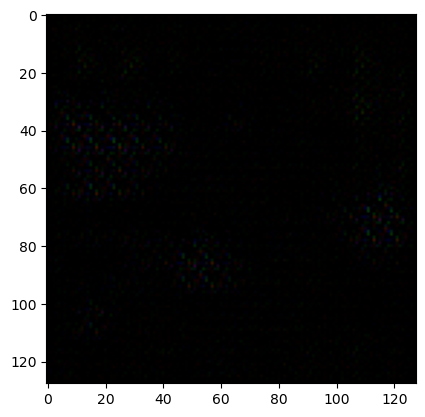

In [ ]:
%matplotlib inline
loss_fn = nn.MSELoss()
epochs = 100
T = 1000
device = "cuda"
betas = get_betas(T).to(device)
alphas , alpha_tilda = calculate_alpha(betas)
model = model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    losses = []
    for i,(img,_) in enumerate(train_dl):
        img = img.to(device)
        noise = torch.randn_like(img).to(device)
        img = dummy_forward(img,T,alpha_tilda,device)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output,noise)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dl)}")

    random = torch.randn(1,3,128,128).to(device)
    image = model(random).squeeze(0).cpu().detach()
    plot_image(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0075997137..0.22986065].


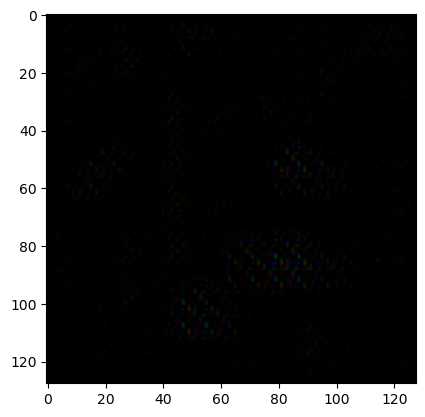

In [20]:
random = torch.randn(1,3,128,128).to(device)
image = model(random).squeeze(0).cpu().detach()
plot_image(image)
